In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plots_dir = Path("/kellogg/proj/lgg3230/SteppingStones/results/plots/stylized_facts")
plots_dir.mkdir(parents=True, exist_ok=True)

In [3]:
df_year_end = pd.read_stata("/kellogg/proj/lgg3230/SteppingStones/data/interim/sample/RAIS_panel_endyear.dta",convert_categoricals=False)
df_quiters = pd.read_stata("/kellogg/proj/lgg3230/SteppingStones/data/interim/quit_spells/RAIS_panel_quits.dta",convert_categoricals=False)
df_ipca = pd.read_csv("/kellogg/proj/lgg3230/SteppingStones/data/raw/ipca.csv")

In [5]:
# merge ipca to df_year_end
d_year_end_ipca = df_year_end.merge(df_ipca, how='left', left_on=['year'], right_on=['year'])
d_year_end_ipca[['year','PIS','ipca_2015']].head()

,year,PIS,ipca_2015
0,2007,0,60.79494
1,2007,10000000113,60.79494
2,2007,10000000970,60.79494
3,2007,10000009145,60.79494
4,2007,10000009196,60.79494


In [6]:
# deflate wage variables in d_year_end_ipca:

wage_vars = ['remmedr', 'remdezr', 'remmedr_h', 'remdezr_h']

# create new deflated wage variables
for var in wage_vars:
    deflated_var = 'r_' + var 
    d_year_end_ipca[deflated_var] = d_year_end_ipca[var] / d_year_end_ipca['ipca_2015'] * 100
    loged_var = 'l' + deflated_var
    d_year_end_ipca[loged_var] = np.log(d_year_end_ipca[deflated_var].replace(0, np.nan))

d_year_end_ipca[['year','PIS','ipca_2015'] + wage_vars + ['r_' + var for var in wage_vars] + ['l' + 'r_' + var for var in wage_vars]].head()

,year,PIS,ipca_2015,remmedr,remdezr,remmedr_h,remdezr_h,r_remmedr,r_remdezr,r_remmedr_h,r_remdezr_h,lr_remmedr,lr_remdezr,lr_remmedr_h,lr_remdezr_h
0,2007,0,60.79494,1021.50,1033.58,5.873390,5.942847,1680.238523,1700.108598,9.660985,9.775233,7.426691,7.438447,2.268096,2.279852
1,2007,10000000113,60.79494,553.50,563.01,2.893180,2.942889,910.437614,926.080363,4.758915,4.840681,6.813925,6.830961,1.560020,1.577055
2,2007,10000000970,60.79494,4226.59,3698.73,22.092655,19.333497,6952.206891,6083.943840,36.339628,31.801162,8.846814,8.713408,3.592909,3.459503
3,2007,10000009145,60.79494,6683.88,0.00,51.241030,0.000000,10994.138679,0.000000,84.285025,0.000000,9.305118,NaN,4.434204,NaN
4,2007,10000009196,60.79494,1778.24,1693.44,51.122355,48.684453,2924.980276,2785.494983,84.089819,80.079778,7.981043,7.932181,4.431886,4.383023


In [7]:
# Generate quality of origin firms according to deflated average wages over the years

df_origin_quality = (d_year_end_ipca.groupby('identificad').agg(
    avg_r_remmedr = ('r_remmedr', 'mean'),
    avg_r_remdezr = ('r_remdezr', 'mean'),
    avg_r_remmedr_h = ('r_remmedr_h', 'mean'),
    avg_r_remdezr_h = ('r_remdezr_h', 'mean'),
    avg_lr_remmedr = ('lr_remmedr', 'mean'),
    avg_lr_remdezr = ('lr_remdezr', 'mean'),
    avg_lr_remmedr_h = ('lr_remmedr_h', 'mean'),
    avg_lr_remdezr_h = ('lr_remdezr_h', 'mean')
).reset_index())




df_origin_quality['identificad'].is_unique 

True

In [8]:
# Generate quality of origin by year:

df_origin_quality_year = (d_year_end_ipca.groupby(['year','identificad']).agg( 
    avg_r_remmedr_yearly = ('r_remmedr', 'mean'),
    avg_r_remdezr_yearly = ('r_remdezr', 'mean'),
    avg_r_remmedr_h_yearly = ('r_remmedr_h', 'mean'),
    avg_r_remdezr_h_yearly  = ('r_remdezr_h', 'mean'), 
    avg_lr_remmedr_yearly = ('lr_remmedr', 'mean'),
    avg_lr_remdezr_yearly = ('lr_remdezr', 'mean'),
    avg_lr_remmedr_h_yearly = ('lr_remmedr_h', 'mean'),
    avg_lr_remdezr_h_yearly  = ('lr_remdezr_h', 'mean')
).reset_index())

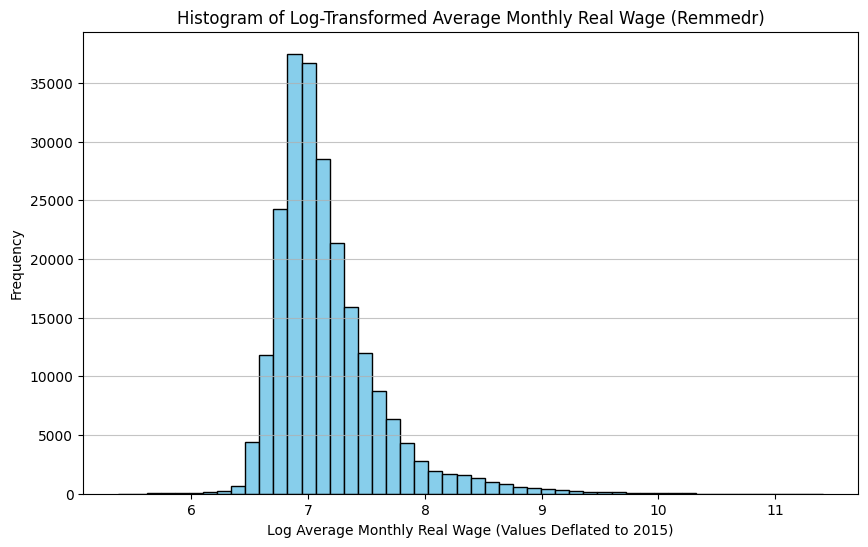

In [9]:
# Generate histogram of avg_remmedr:

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df_origin_quality['avg_lr_remmedr'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Log-Transformed Average Monthly Real Wage (Remmedr)')
plt.xlabel('Log Average Monthly Real Wage (Values Deflated to 2015)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
# Save plot
plt.savefig(plots_dir / 'histogram_avg_remmedr.png')
plt.show()

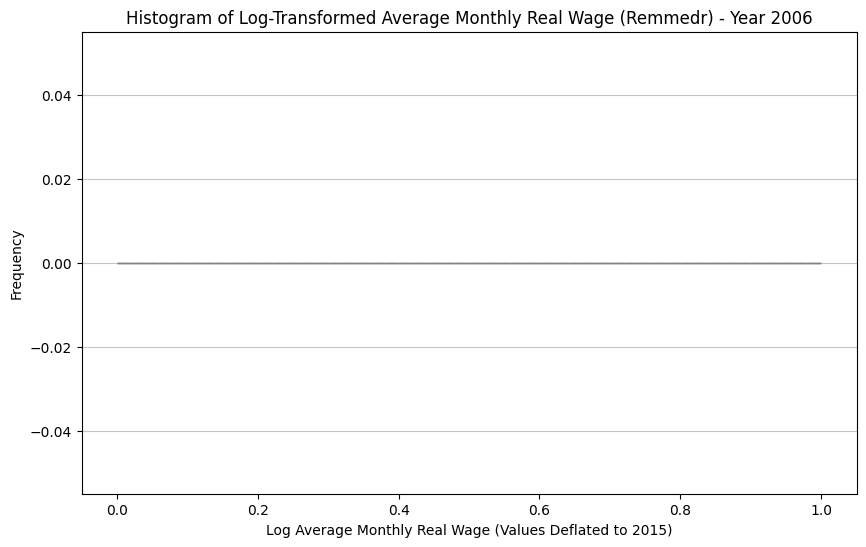

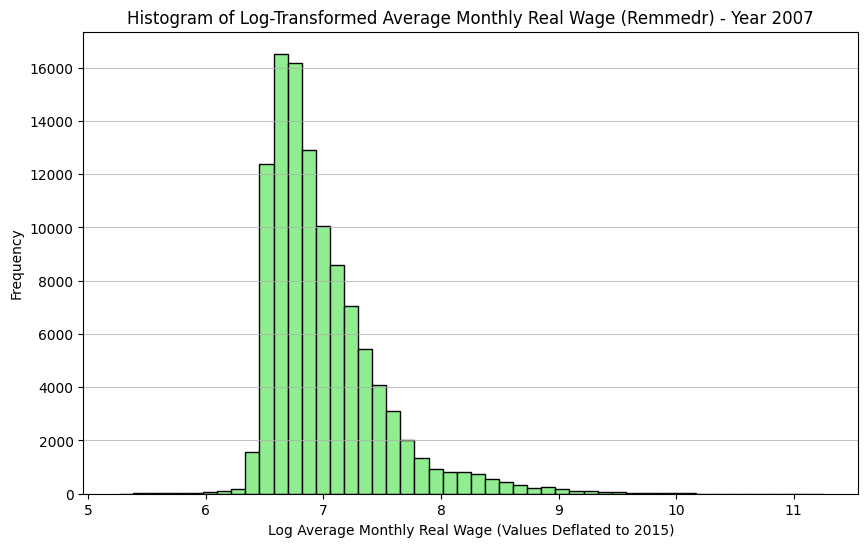

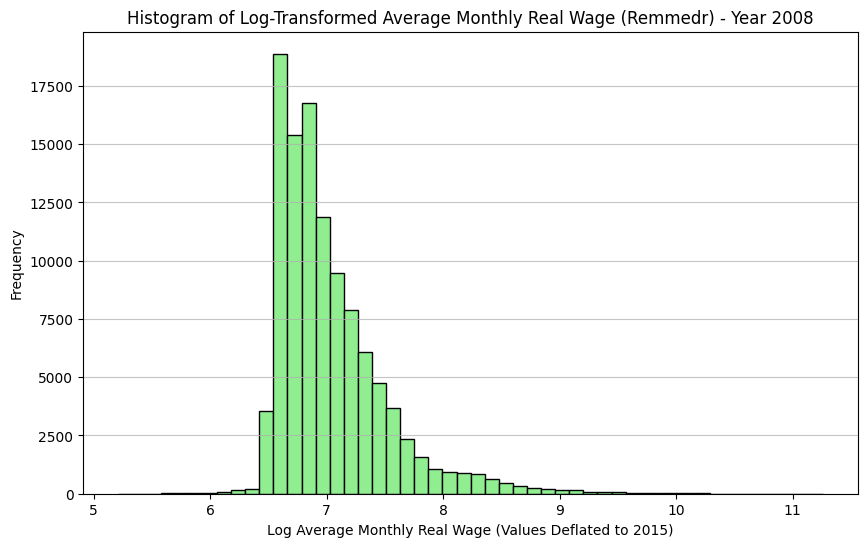

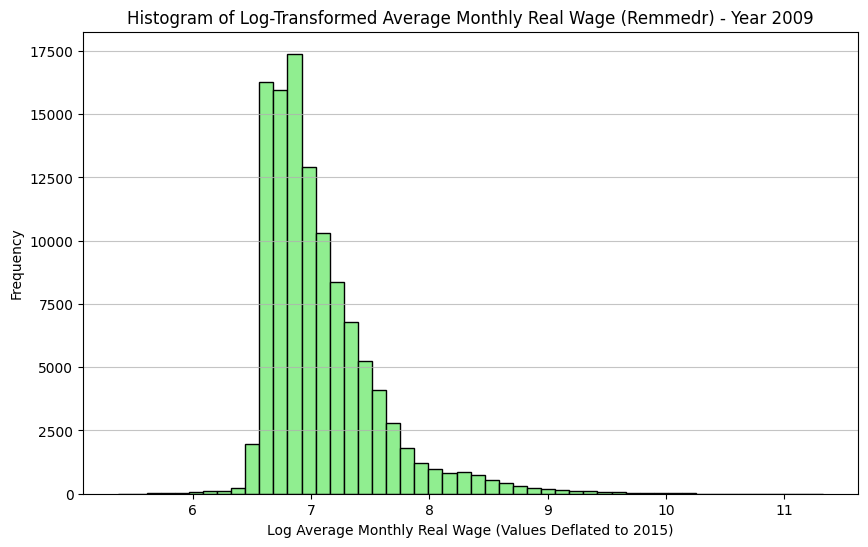

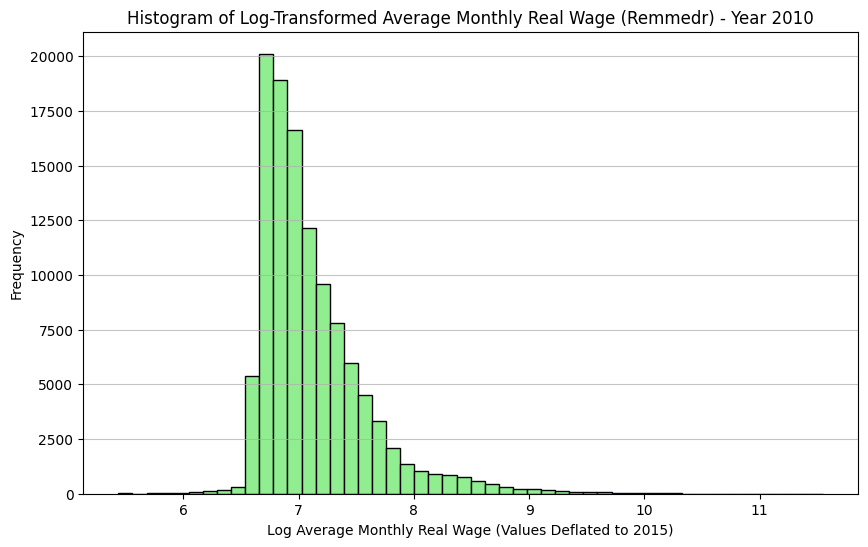

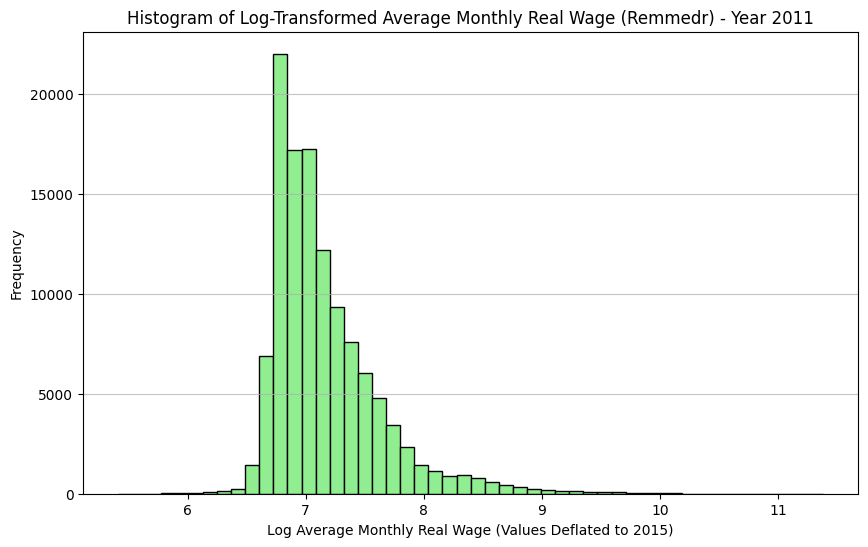

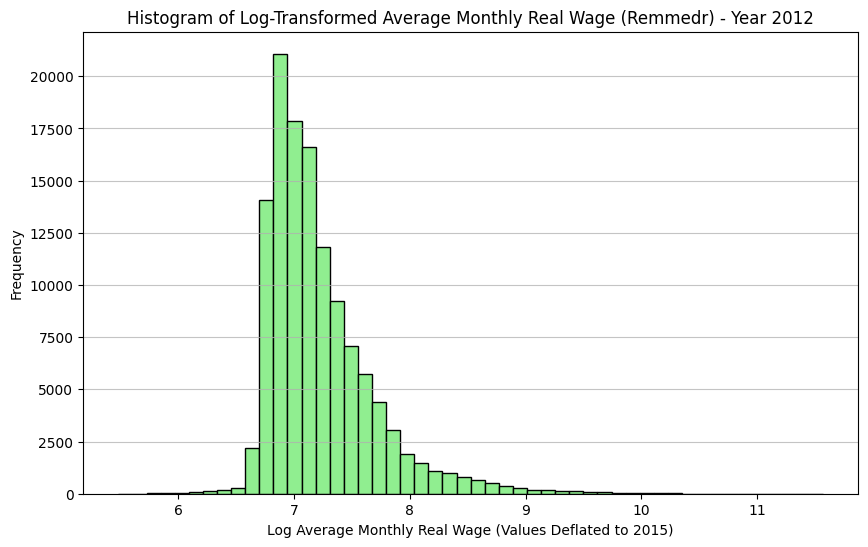

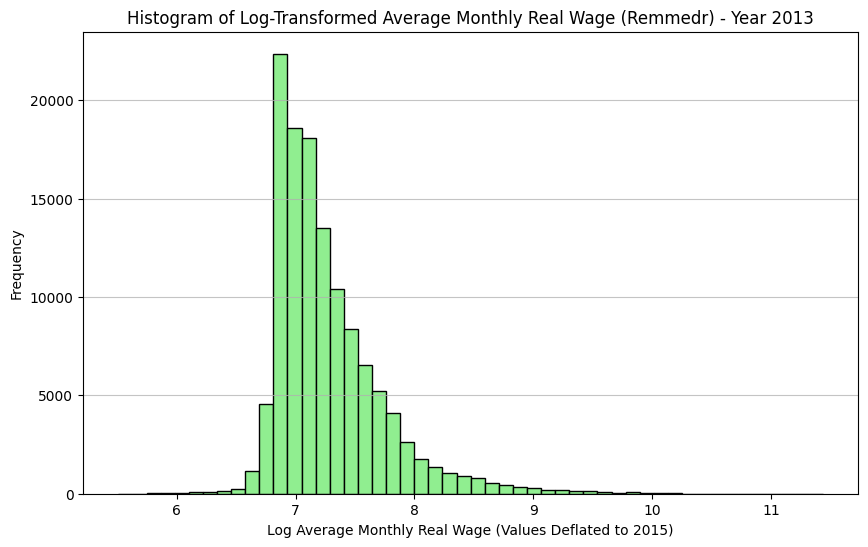

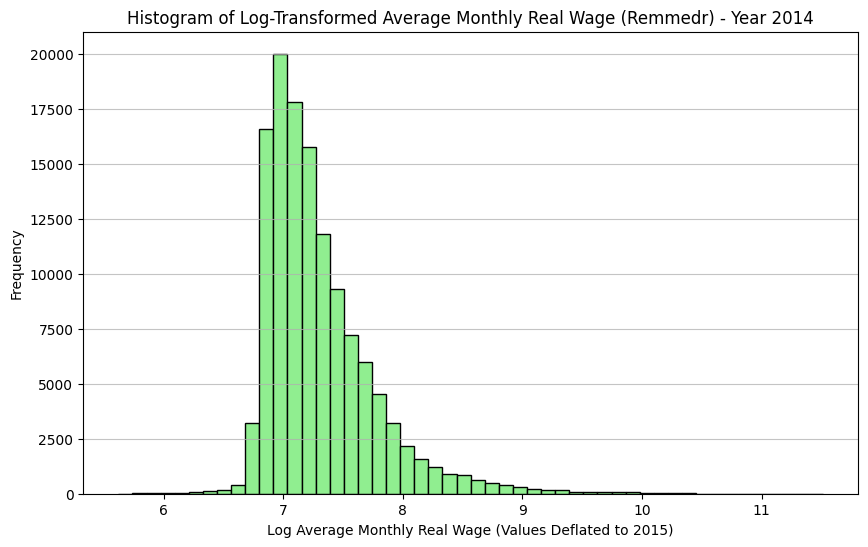

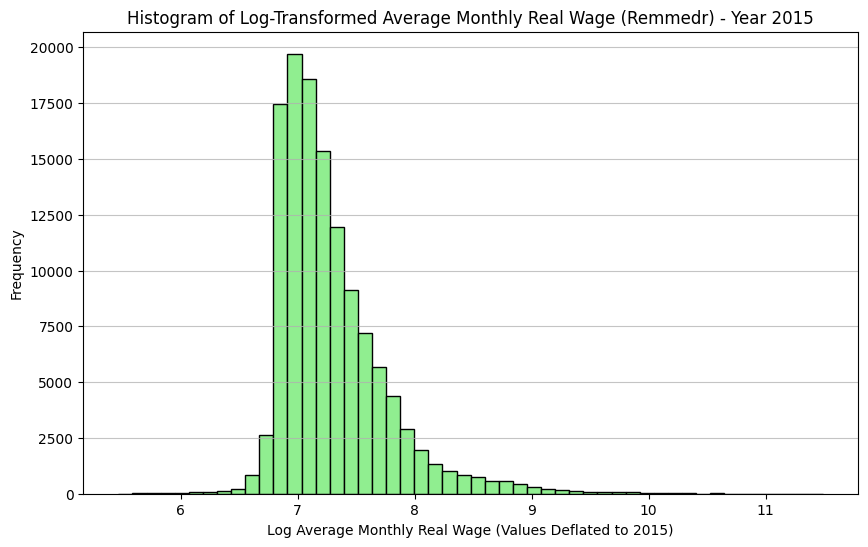

In [10]:
# Now, we make histograms for the yearly origin quality variables, only for lr_remmedr_yearly, but we do one graph per year:
for year in range(2006,2016):
    df_temp = df_origin_quality_year[df_origin_quality_year['year'] == year]
    plt.figure(figsize=(10,6))
    plt.hist(df_temp['avg_lr_remmedr_yearly'], bins=50, color='lightgreen', edgecolor='black')
    plt.title(f'Histogram of Log-Transformed Average Monthly Real Wage (Remmedr) - Year {year}')
    plt.xlabel('Log Average Monthly Real Wage (Values Deflated to 2015)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    # Save plot
    plt.savefig(plots_dir / f'histogram_avg_remmedr_{year}.png')
    # plt.show()



# Now, instead of individual yearly histogram plots, we do lines and overlay each year to see evolution of quality distribution:



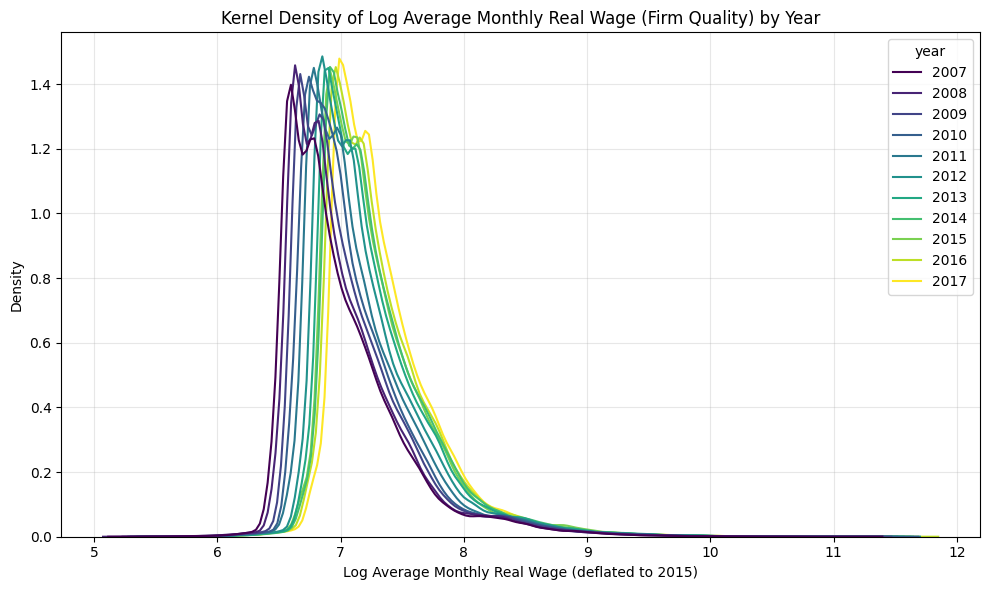

In [11]:
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=df_origin_quality_year,
    x='avg_lr_remmedr_yearly',
    hue='year',
    common_norm=False,   # allows densities to vary freely
    fill=False,          # only outlines
    linewidth=1.5,
    palette='viridis'
)

plt.title('Kernel Density of Log Average Monthly Real Wage (Firm Quality) by Year')
plt.xlabel('Log Average Monthly Real Wage (deflated to 2015)')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(plots_dir / 'kernel_density_firm_quality_over_years.png')
plt.show()

In [ ]:
# Find quiters of year t in end of year data of year t+1. we need to get the origin and destination firm qualities

df_quiters['origin_id'] = df_quiters['identificad']
df_quiters['origin_year'] = df_quiters['year']
df_quiters['destination_year_1'] = df_quiters['year'] + 1

dest_matches = df_quiters.merge(
    d_year_end_ipca[['PIS','identificad', 'year']],
    left_on=['PIS', 'destination_year'],
    right_on=['PIS', 'year'],
    how='left',
    suffixes=('_origin', '_destination')
)

In [16]:
dest_matches[['PIS', 'identificad_origin', 'origin_year', 'identificad_destination', 'destination_year']].head()
dest_matches['identificad_destination'].isna().mean()

np.float64(0.6567138721431091)

There is a potential issue with this quality measure:  I am not excluding the people who swithced jobs from one year to the next